# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test.h5', 'r') as hf:
    y = hf['labels_test'][:]
    
with h5py.File('/data/joint_scoring/img_test.h5', 'r') as hf:
    imgs = hf['img_test'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19611,), (19611, 150, 150, 1))

In [3]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/data/joint_scoring/models/20171108_195245.h5")

## Build truncated model

In [4]:
config = loaded_model.get_config()

In [5]:
config = config[0:48]

In [6]:
model = Sequential.from_config(config)

In [7]:
weights = loaded_model.get_weights()

In [8]:
model.set_weights(weights)

## Get embeddings

In [9]:
embeddings = model.predict(imgs)

In [19]:
from sklearn.manifold import TSNE

x_2d = TSNE(n_components=2).fit_transform(embeddings)

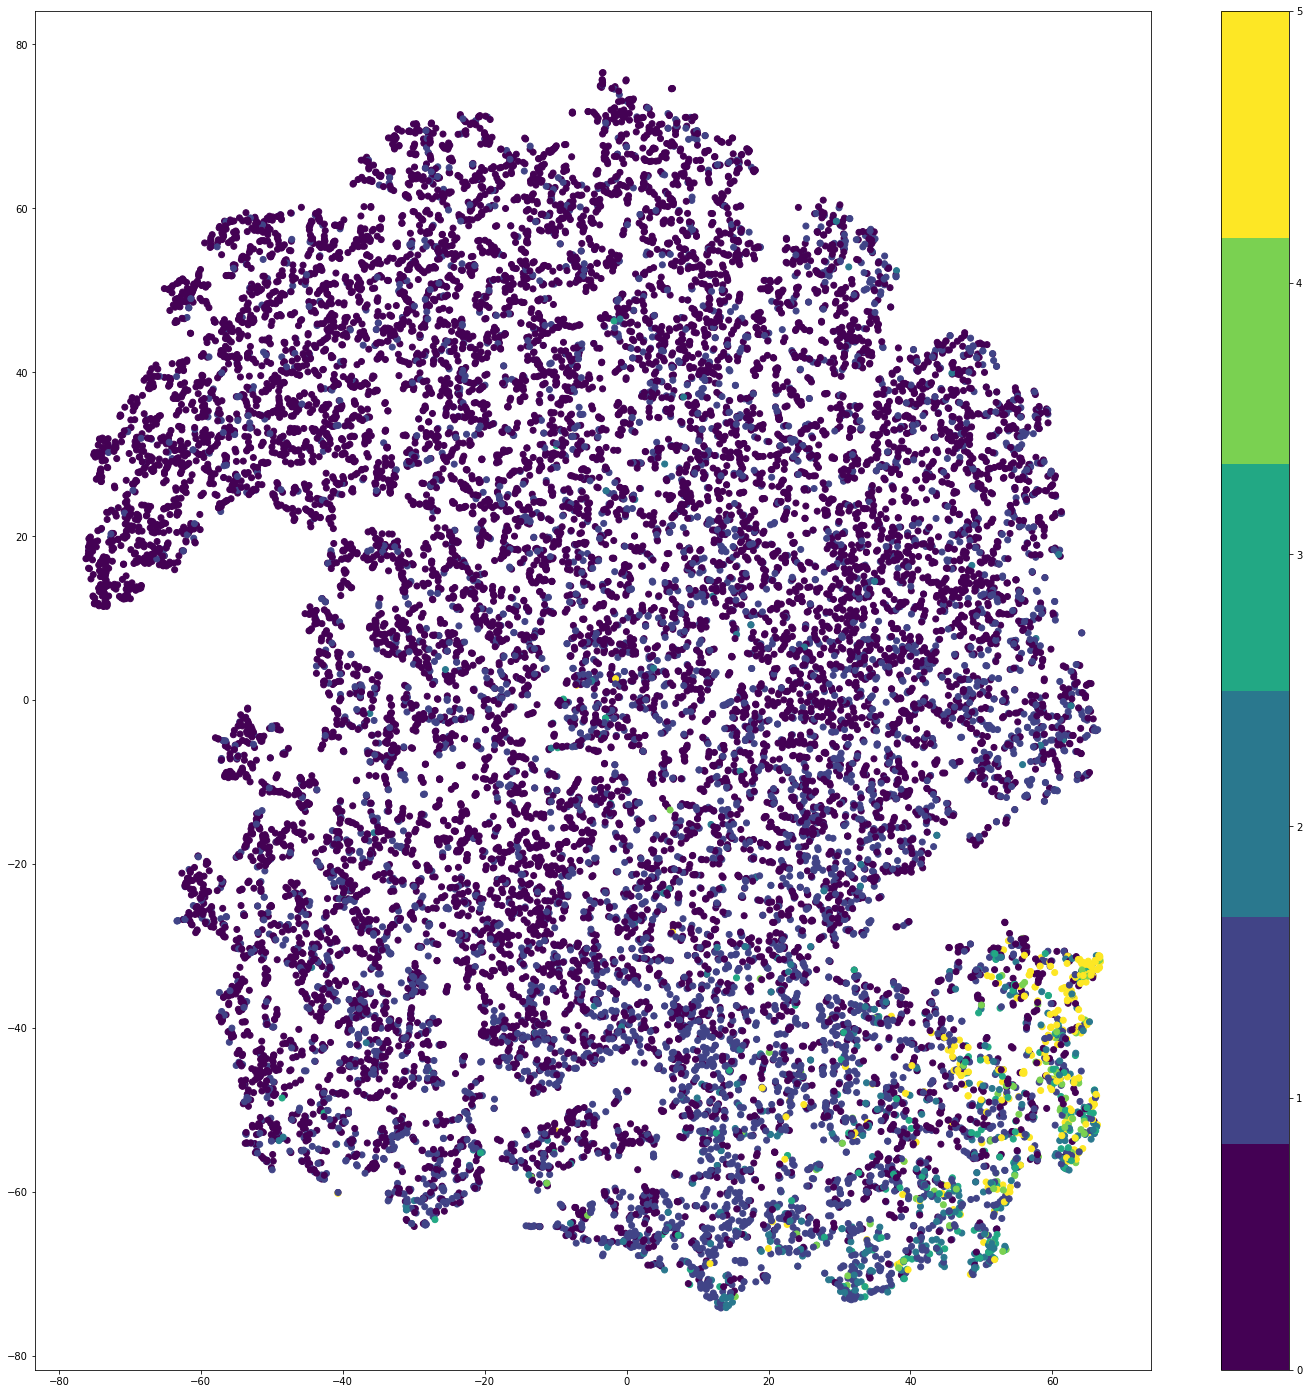

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis", 6))
plt.colorbar()
plt.show()

In [12]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3).fit_transform(embeddings)

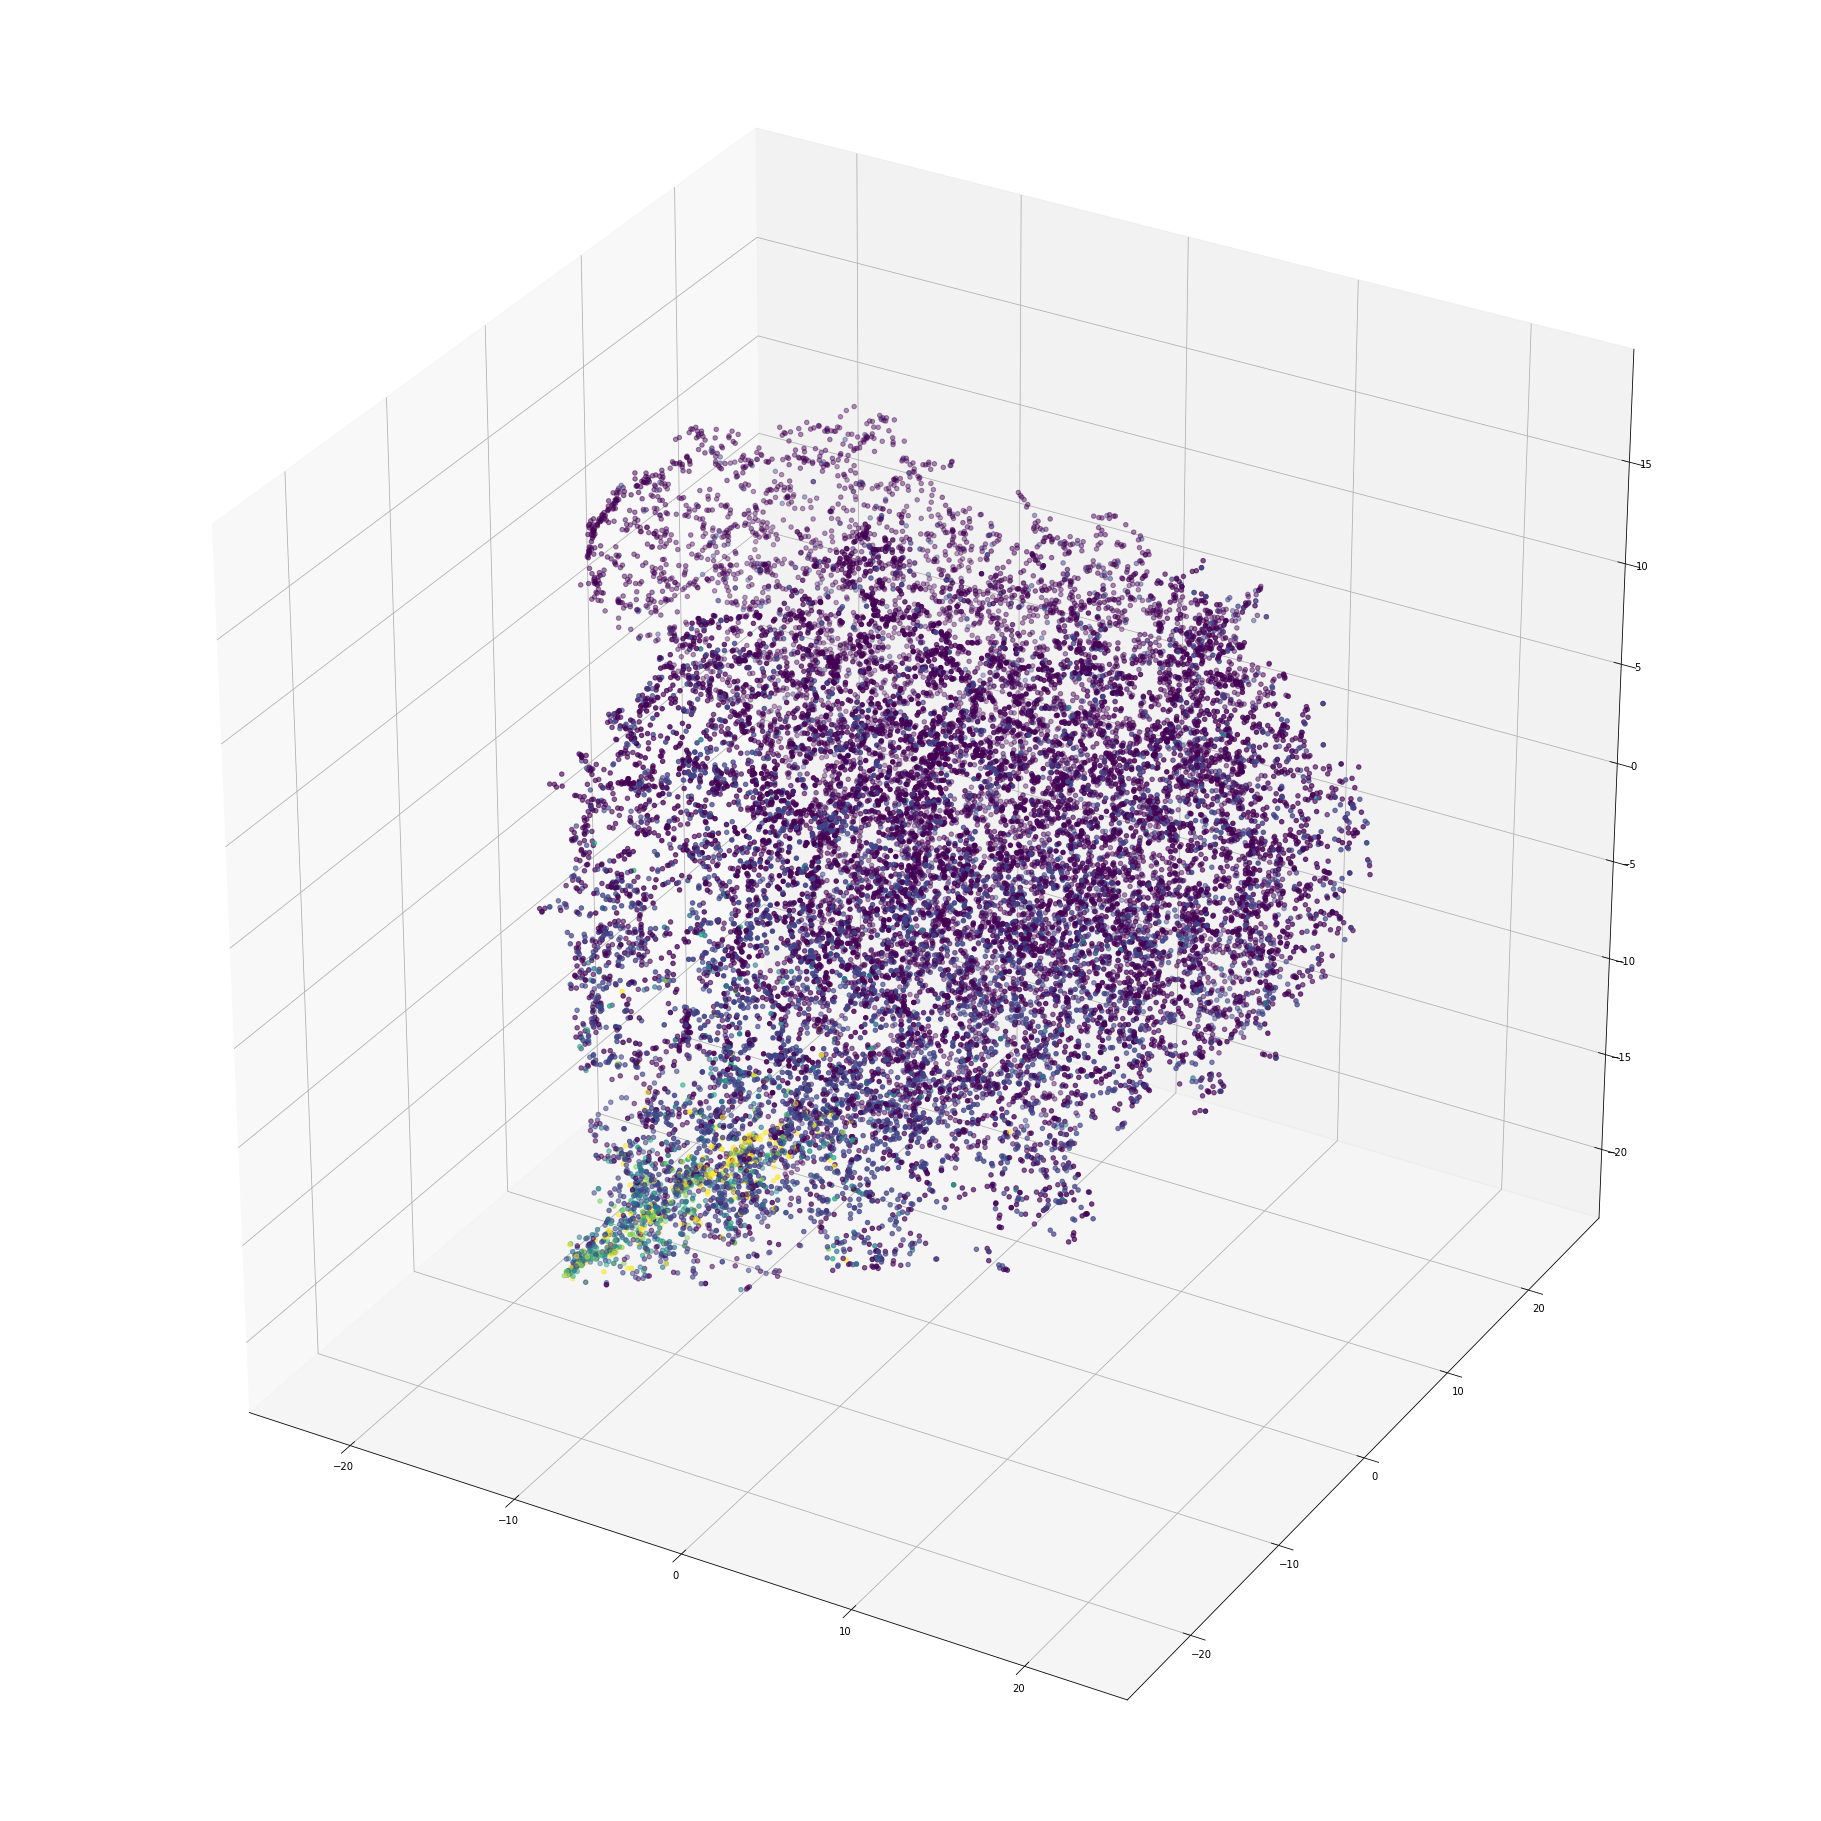

In [18]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis", 6))
pyplot.show()

In [40]:
!pip3 install skimage --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(25, 25)) for x in imgs]
imgs_resized = np.array(imgs_resized)

  Using cached skimage-0.0.tar.gz
    Complete output from command python setup.py egg_info:
    
    *** Please install the `scikit-image` package (instead of `skimage`) ***
    
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-9rl0etu7/skimage/


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [43]:
from IPython.display import clear_output
res = 4000 # resolution of plot
cval = 0 # background colour

images = imgs_resized
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [44]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [47]:
res_x, res_y

(4000, 4218.2791916142096)

In [49]:
res_y=res_y.astype("int16")

In [ ]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

fig = pyplot.figure(figsize=(25,25))
fig.imshow(canvas)
plt.show()